# Hacking the XGBoost

By Raul Sanchez-Vazquez

## Introduction

Ever wonder how does xgboost trains a tree?.

In this example I'll show how xgboost performs **split finding** and once the split is found how to find the **optimal weights**.

In [37]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
import xgboost as xgb
from xgboost import plot_tree

data = datasets.load_boston()

X = pd.DataFrame(
    data['data'],
    columns=data['feature_names'])
for f in X.columns:
    X[f] = X[f].astype(int)
y = pd.Series(data['target'])

The dataset used in this example is the Boston dataset, with features as `int` just to speedup a split finding and simplify visualization.

## Train a tree

To compare our final solution and simplify our explanation, we'll create a very basic XGB model as follow:

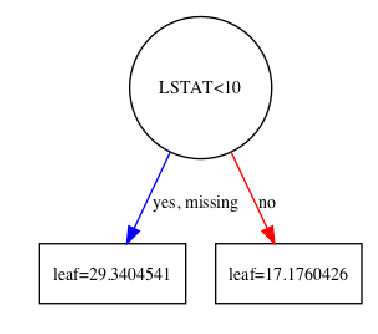

In [39]:
reg_lambda = 1
base_score = 0
learning_rate = 1
max_depth = 1
n_estimators = 1

model = xgb.XGBRegressor(
    tree_method='exact',
    objective='reg:linear',
    base_score=base_score,
    learning_rate=learning_rate,
    reg_lambda=reg_lambda,
    max_depth=max_depth,
    n_estimators=n_estimators,
    random_state=0)

model.fit(X, y)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax = plot_tree(model, num_trees=0, ax=ax)

## Loss function

In this example the task performed is a regression, therefore the loss used is **Mean Squared error**, so errors are penalized by: 

$(\hat{y}^{(t-1)} - y)^2$, 

which has the following First derivative:

$g_i = \partial_{\hat{y}^{(t-1)}} (\hat{y}^{(t-1)} - y)^2 = 2(\hat{y}^{(t-1)} - y_i)$


and Second derivative:

$h_i = \partial^2_{\hat{y}^{(t-1)}} (\hat{y}^{(t-1)} - y)^2 = 2$

In the equations above, $\hat{y}^{(t-1)}$ refers to the last predicted value. For us, as this is the first and unique tree, the last predicted value is the XGB parameter: `base_score`.

In [44]:
g_i = 2 * (base_score - y)
h_i = pd.Series([2] * y.shape[0])

## Split finding

The **Algorithm 1: Exact Greedy Algorithm for Split Finding** can be coded in python as follow:

(0, 60)

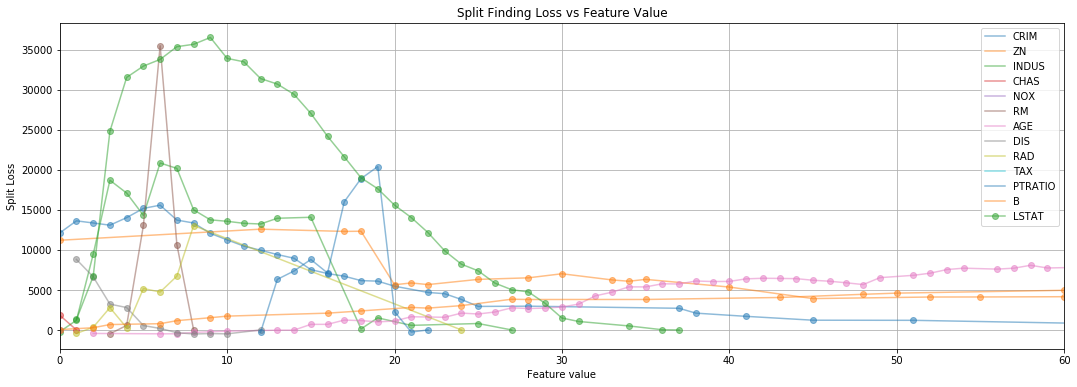

In [45]:
gain = 0
G = g_i.sum()
H = h_i.sum()

score = 0
best_splits = []

fig, ax = plt.subplots(1, 1, figsize=(18, 6))
for k in X.columns:
    G_L, H_L = 0, 0
    local_scores = [] # This is used to store scores
    X_grp = X.groupby(k) # This is used to slice the dataframe by a give feature value
    
    X_f_sorted = sorted(X[k].unique())
    for j in X_f_sorted:
        # Get the X instances that have a specific feature value
        j_idxs = X_grp.get_group(j).index.tolist()
        
        # Compute split score
        G_L += g_i[j_idxs].sum()
        H_L += h_i[j_idxs].sum()

        G_R = G - G_L
        H_R = H - H_L

        local_score = (
            G_L**2 / (H_L + reg_lambda)
        ) + (
            G_R**2 / (H_R + reg_lambda)
        ) - (
            G**2 / (H + reg_lambda)
        )
        
        # Store scores
        local_scores.append({
            'index': j,
            k: local_score})
    
    # The code below just makes a visualization of what the split finding is doing
    local_scores = pd.DataFrame(
        local_scores
    ).set_index('index')[k]

    feature_value = local_scores.idxmax()
    score_max = local_scores.max()
    best_splits.append([k, feature_value, score_max])

    local_scores.plot(
        grid=True,
        legend=True,
        marker='o',
        alpha=0.5,
        ax=ax)
ax.set_title('Split Finding Loss vs Feature Value')
ax.set_xlabel('Feature value')
ax.set_ylabel('Split Loss')
ax.set_xlim(0, 60)

In the plot above, each line corresponds to a feature. Single dots on the line are actual feature values and the corresponding score obtained if one decides to make the split at that feature value.

As one can observe, the feature that performed best was the green line: `LSTAT` at around a feature value of: `9`.

In the table below can be found the best score for each feature:

In [48]:
best_splits_df = pd.DataFrame(
    best_splits,
    columns=['Feature', 'Best Split Value', 'Split Loss'])

best_splits_df.sort_values('Split Loss', ascending=False, inplace=True)
best_splits_df

,Feature,Best Split Value,Split Loss
12,LSTAT,9,36554.340409
5,RM,6,35513.313904
2,INDUS,6,20865.576723
10,PTRATIO,19,20412.074936
9,TAX,411,16822.735776
0,CRIM,6,15592.469240
8,RAD,8,13047.366342
1,ZN,12,12594.972701
6,AGE,76,10303.895101
11,B,344,10231.893136


# Optimal weight

Once the splits are done it is necesary to compute the optimal weight on each leaf.
The Equation (5) on the xgboost paper shows how to compute leaf weights:

In [49]:
# Optimal weight
feature = best_splits_df.iloc[0]['Feature']
th = best_splits_df.iloc[0]['Best Split Value']
L = y[X[feature] <= th]
R = y[X[feature] > th]

print("Left Leaf:" , np.round(-1 * (base_score - L).sum() / (L.shape[0] + reg_lambda), 4))
print("Right Leaf:" , np.round(-1 * (base_score - R).sum() / (R.shape[0] + reg_lambda), 4))

Left Leaf: 29.3405
Right Leaf: 17.176


If you feel courious, I've also made some slides guiding step-by-step the expansion for some equations of the xgboost paper. You can find them in this repo at the presentation fold. 

:) cheers!